In [1]:
# pip install tslearn

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.metrics import dtw, cdist_dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler

# helper function
def to_dict(data):
    dict = {}
    for i in data.sort_values('cluster')['cluster'].unique():
        l = data[data['cluster'] == i].index.to_list()
        dict[f'cluster{i}'] = l
    return dict

In [3]:
# read csv data, set index using "Date" column
ccy = pd.read_csv('../data/ccy1996_to_2023(c).csv')
ccy.set_index('Date', inplace=True)
ccy.head()

,USDAUD,USDNZD,USDEUR,USDGBP,USDCAD,USDCHF,USDJPY,AUDNZD,EURAUD,GBPAUD,...,EURGBP,EURCAD,EURCHF,EURJPY,GBPCAD,GBPCHF,GBPJPY,CADCHF,CADJPY,CHFJPY
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-05,1.337345,1.520797,0.778634,0.644122,1.35835,1.16150,105.410,1.13720,1.71755,2.07625,...,0.82725,1.7445,1.49170,135.235,2.10885,1.80325,163.48,0.85510,77.52,90.655
1996-01-12,1.344990,1.508637,0.780457,0.646621,1.36305,1.16300,105.250,1.12165,1.72335,2.07875,...,0.82850,1.7466,1.49015,134.855,2.10810,1.79855,162.77,0.85315,77.23,90.525
1996-01-19,1.359897,1.505457,0.802504,0.663350,1.36600,1.19230,105.345,1.10705,1.69455,2.05005,...,0.82660,1.7022,1.48570,131.275,2.05925,1.79735,158.81,0.87285,77.12,88.355
1996-01-26,1.356208,1.499813,0.815993,0.665779,1.38175,1.21100,106.650,1.10585,1.66205,2.03705,...,0.81590,1.6933,1.48410,130.695,2.07540,1.81895,160.19,0.87640,77.18,88.065
1996-02-02,1.319871,1.477432,0.807559,0.656039,1.37595,1.21445,106.450,1.11935,1.63440,2.01190,...,0.81240,1.7038,1.50385,131.815,2.09735,1.85120,162.26,0.88265,77.36,87.655


In [4]:
# initiate scaler
ss = StandardScaler()

# scale the initial data
# This is because the JPY pair the value tend to be bigger
# As DTW concerns about the distance amongst different pairs, need to scale
scaled = ss.fit_transform(ccy)
scaled_ccy = pd.DataFrame(data=scaled,
                         columns=ccy.columns,
                         index=ccy.index)

In [5]:
# Generate a list that can fit into the DTW matrics
list = []
for c in scaled_ccy.columns:
    data  = scaled_ccy[c]
    list.append(data)

# Generate distance matrix, or it also can be considered as similarity matrix
matrix = cdist_dtw(list)
matrix.shape

(28, 28)

In [6]:
# convert to dataframe
matrix_df = pd.DataFrame(data=matrix,
                        columns=scaled_ccy.columns,
                        index=scaled_ccy.columns)

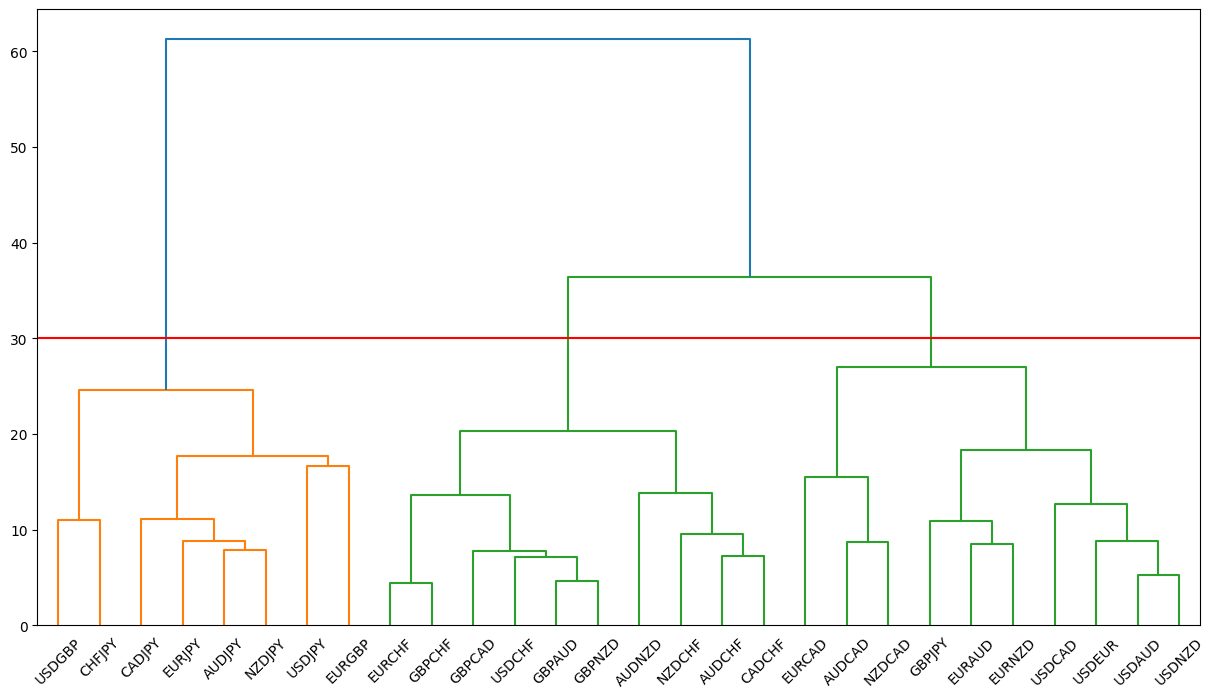

In [7]:
# hierarchical clustering and plot dendragram
plt.figure(figsize=(15,8))
distance = abs(matrix_df)
Z = linkage(squareform(distance), 'complete')

dendrogram(Z, labels=ccy.columns, orientation='top', leaf_rotation=45)
plt.axhline(30, color='r')
plt.show()

In [8]:
# set up threshold
threshold = 30

# assign cluster
labels = fcluster(Z, threshold, criterion='distance')

# convert to DataFrame for better manipulation
cluster = pd.DataFrame(index = ccy.columns, data=labels)
cluster.rename(columns={0:'cluster'}, inplace=True)

# print out resulted cluster information
for i in range(1,len(np.unique(labels))+1):
    print(cluster[cluster['cluster']==i])

# export to csv for later
dict = to_dict(cluster)
cluster_df = pd.DataFrame.from_dict(dict, orient='index')
cluster_df.to_csv('../data/DTW_cluster.csv', index=False)

        cluster
USDGBP        1
USDJPY        1
AUDJPY        1
NZDJPY        1
EURGBP        1
EURJPY        1
CADJPY        1
CHFJPY        1
        cluster
USDCHF        2
AUDNZD        2
GBPAUD        2
AUDCHF        2
GBPNZD        2
NZDCHF        2
EURCHF        2
GBPCAD        2
GBPCHF        2
CADCHF        2
        cluster
USDAUD        3
USDNZD        3
USDEUR        3
USDCAD        3
EURAUD        3
AUDCAD        3
EURNZD        3
NZDCAD        3
EURCAD        3
GBPJPY        3


This method looks to have the most distinctive separation of cluster. Cluster 1 consists of JPY mostly, 2 consists of EU vs AU/NZ, while 3 involves US/CA vs the rest of the world.  
Technically the 28 pairs have been seperated into three different sets of economies.  
This is particularly helpful as we now have three distinct factors that are potentially driving the FX market.  

To illustrate further, below are the price movement of each cluster

<AxesSubplot: xlabel='Date'>

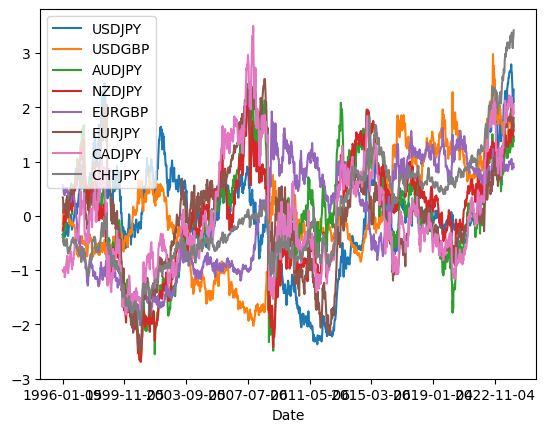

In [9]:
scaled_ccy[['USDJPY', 'USDGBP','AUDJPY', 'NZDJPY', 'EURGBP', 'EURJPY', 'CADJPY', 'CHFJPY']].plot()

<AxesSubplot: xlabel='Date'>

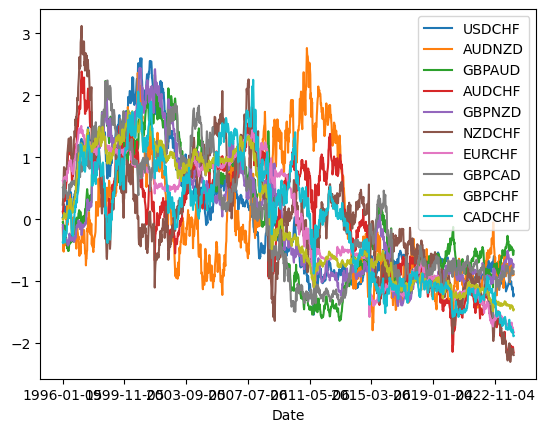

In [10]:
scaled_ccy[['USDCHF', 'AUDNZD', 'GBPAUD', 'AUDCHF', 'GBPNZD', 'NZDCHF', 'EURCHF', 'GBPCAD', 'GBPCHF', 'CADCHF']].plot()

<AxesSubplot: xlabel='Date'>

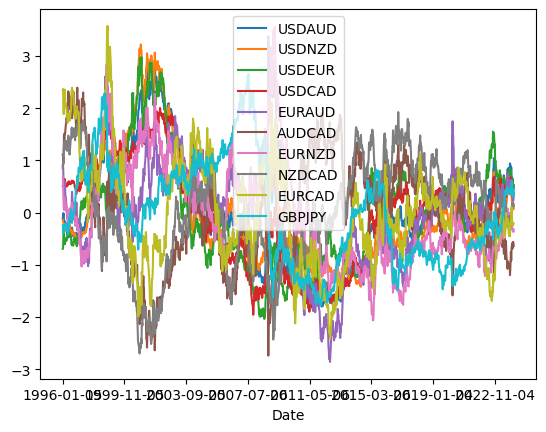

In [11]:
scaled_ccy[['USDAUD', 'USDNZD', 'USDEUR', 'USDCAD', 'EURAUD', 'AUDCAD', 'EURNZD', 'NZDCAD', 'EURCAD', 'GBPJPY']].plot()